# Modeling Price with Regularized Linear Model & Xgboost

We would like to model the price of a house, we know that the price depends on the location of the house, square footage of a house, year built, year renovated, number of bedrooms, number of garages, etc. So those factors contribute to the pattern — premium location would typically lead to a higher price. However, all houses within the same area and have same square footage do not have the exact same price. The variation in price is the noise. Our goal in price modeling is to model the pattern and ignore the noise. The same concepts apply to modeling hotel room prices too.
Therefore, to start, we are going to implement regularization techniques for linear regression of house pricing data.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from xgboost import XGBRegressor, plot_importance 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [2]:
pd.set_option('display.float_format', lambda x: '{:.5f}'.format(x))
df = pd.read_csv(r'C:\Users\emaurkj\Desktop\Daily\dataset\house_price\train.csv')
print(df.shape)


###########################


# print(df.head())

(1460, 81)


In [3]:
(df.isnull().sum()/len(df)).sort_values(ascending =False)[:20]

PoolQC         0.99521
MiscFeature    0.96301
Alley          0.93767
Fence          0.80753
FireplaceQu    0.47260
LotFrontage    0.17740
GarageCond     0.05548
GarageType     0.05548
GarageYrBlt    0.05548
GarageFinish   0.05548
GarageQual     0.05548
BsmtExposure   0.02603
BsmtFinType2   0.02603
BsmtFinType1   0.02534
BsmtCond       0.02534
BsmtQual       0.02534
MasVnrArea     0.00548
MasVnrType     0.00548
Electrical     0.00068
Utilities      0.00000
dtype: float64

The good news is that we have many features to play with (81), the bad news is that 19 features have missing values, and 4 of them have over 80% missing values. For any feature, if it is missing 80% of values, it can’t be that important, therefore, I decided to remove these 4 features.

In [4]:
df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', ], axis=1, inplace=True)

# Explore Features
Target feature distribution


 mu = 180921.20 and sigma = 79415.29



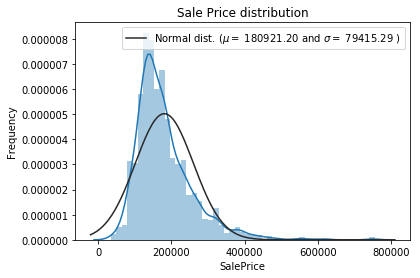

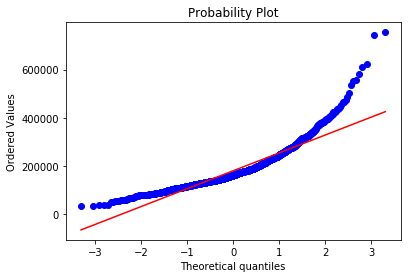

In [5]:
sns.distplot(df['SalePrice'], fit=norm)
# Get the fitted parameters used by the function

(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sale Price distribution')


#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show();

The target feature - SalePrice is right skewed. As linear models like normally distributed data , we will transform SalePrice and make it more normally distributed.


 mu = 12.02 and sigma = 0.40



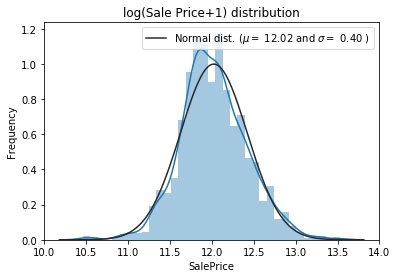

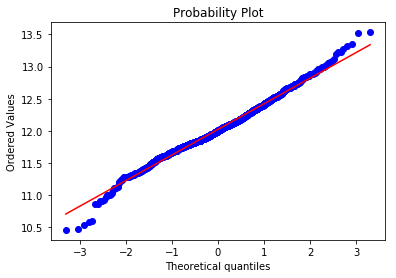

In [6]:
sns.distplot(np.log1p(df['SalePrice']) , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(np.log1p(df['SalePrice']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('log(Sale Price+1) distribution')


#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(np.log1p(df['SalePrice']), plot=plt)
plt.show();

# Correlation between numeric features

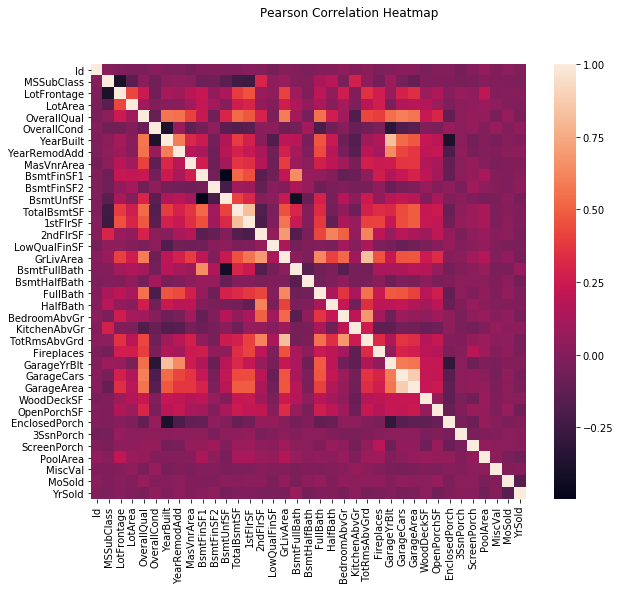

In [7]:
pd.set_option('precision',2)
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(['SalePrice'],axis=1).corr(), square=True,)
plt.suptitle("Pearson Correlation Heatmap")
plt.show();

There exists strong correlations between some of the features. For example, GarageYrBlt and YearBuilt, TotRmsAbvGrd and GrLivArea, GarageArea and GarageCars are strongly correlated. They actually express more or less the same thing. I will let ElasticNetCV to help reduce redundancy later.

# Correlation between SalePrice and the other numeric features

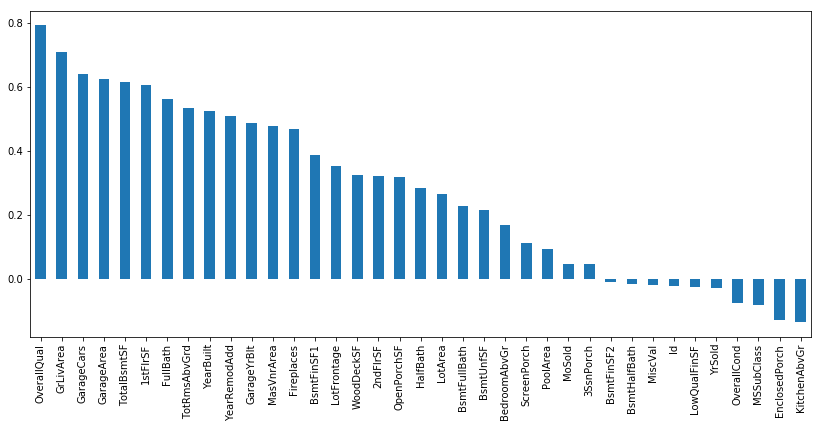

In [8]:
corr_with_sale_price = df.corr()["SalePrice"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_with_sale_price.drop("SalePrice").plot.bar()
plt.show();

The correlation of SalePrice with OverallQual is the greatest (around 0.8). Also GrLivArea presents a correlation of over 0.7, and GarageCars presents a correlation of over 0.6. Let’s look at these 4 features in more detail.

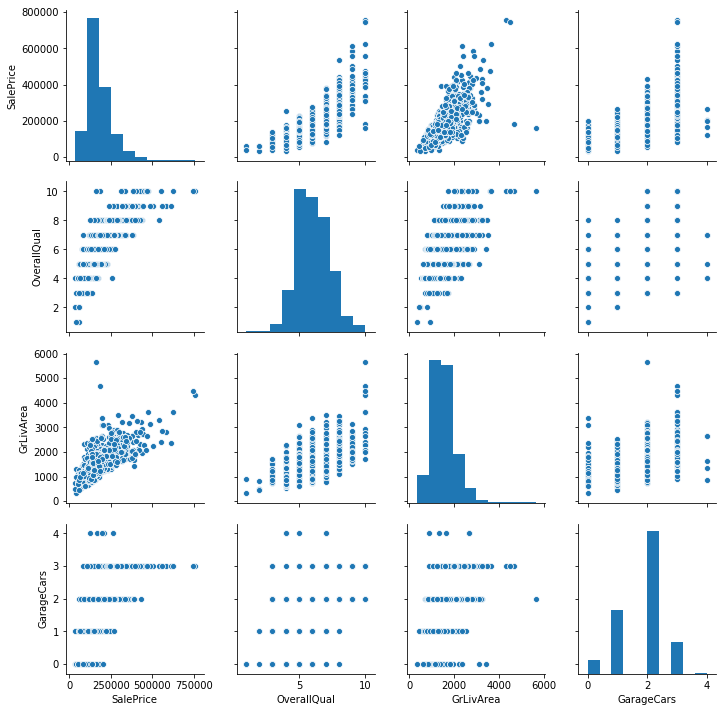

In [9]:
sns.pairplot(df[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars']])
plt.show();

# Feature Engineering
    Log transform features that have a highly skewed distribution (skew > 0.75)
    Dummy coding categorical features
    Fill NaN with the mean of the column.
    Train and test sets split.

In [10]:
df["SalePrice"] = np.log1p(df["SalePrice"])

#log transform skewed numeric features:
numeric_feats = df.dtypes[df.dtypes != "object"].index



skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index


df[skewed_feats] = np.log1p(df[skewed_feats])
df = pd.get_dummies(df)
df = df.fillna(df.mean())

In [11]:
X, y = df.drop(['SalePrice'], axis = 1), df['SalePrice']
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 0)

# ElasticNet
        Ridge and Lasso regression are regularized linear regression models.
        ElasticNet is essentially a Lasso/Ridge hybrid, that entails the minimization of an objective function that 
        includes both L1 (Lasso) and L2 (Ridge) norms.
        ElasticNet is useful when there are multiple features which are correlated with one another.
        The class ElasticNetCV can be used to set the parameters alpha (α) and l1_ratio (ρ) by cross-validation.
        ElasticNetCV: ElasticNet model with best model selection by cross-validation.

# Let’s see what ElasticNetCV is going to select for us.

In [12]:
cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=1e-3, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=6, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)
               
cv_model.fit(X_train, y_train)
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 0.00013634
Optimal l1_ratio: 0.700
Number of iterations 84


0< The optimal l1_ratio <1 , indicating the penalty is a combination of L1 and L2, that is, the combination of Lasso and Ridge.

# Model Evaluation

In [13]:
y_train_pred = cv_model.predict(X_train)
y_pred = cv_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train r2 score:  0.9353546224086693
Test r2 score:  0.8300197440552606
Train RMSE: 0.0962
Test RMSE: 0.1604


The RMSE here is actually RMSLE ( Root Mean Squared Logarithmic Error). Because we have taken the log of the actual values. Here is a nice write up explaining the differences between RMSE and RMSLE.

# Feature Importance

115 features, reduction of 58.33%


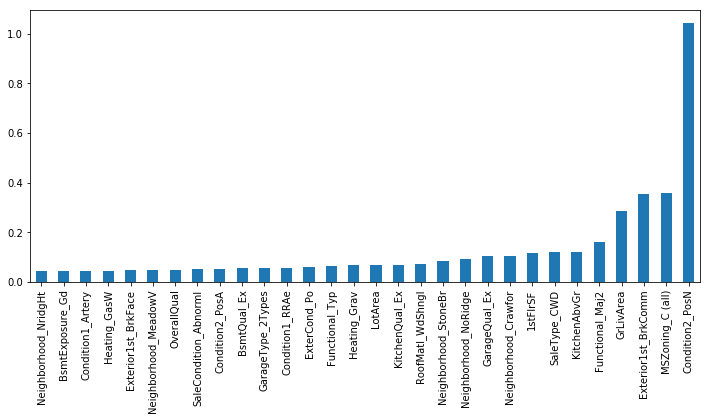

In [14]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(cv_model.coef_))
n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))
feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (12,5));

A reduction of 58.91% features looks productive. The top 4 most important features selected by ElasticNetCV are Condition2_PosN, MSZoning_C(all), Exterior1st_BrkComm & GrLivArea. We are going to see how these features compare with those selected by Xgboost.

# Xgboost
The first Xgboost model, we start from default parameters.

In [15]:
xgb_model1 = XGBRegressor()
xgb_model1.fit(X_train, y_train, verbose=False)
y_train_pred1 = xgb_model1.predict(X_train)
y_pred1 = xgb_model1.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred1, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred1))
train_mse1 = mean_squared_error(y_train_pred1, y_train)
test_mse1 = mean_squared_error(y_pred1, y_test)
train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)
print('Train RMSE: %.4f' % train_rmse1)
print('Test RMSE: %.4f' % test_rmse1)


[00:06:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9548861643673784
Test r2 score:  0.8841840706580213
Train RMSE: 0.0816
Test RMSE: 0.1324


It is already way better an the model selected by ElasticNetCV!


The second Xgboost model, we gradually add a few parameters that suppose to add model’s accuracy.

In [16]:
xgb_model2 = XGBRegressor(n_estimators=1000)
xgb_model2.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred2 = xgb_model2.predict(X_train)
y_pred2 = xgb_model2.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred2, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred2))
train_mse2 = mean_squared_error(y_train_pred2, y_train)
test_mse2 = mean_squared_error(y_pred2, y_test)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
print('Train RMSE: %.4f' % train_rmse2)
print('Test RMSE: %.4f' % test_rmse2)


[00:06:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9799644286390212
Test r2 score:  0.8974369636919164
Train RMSE: 0.0556
Test RMSE: 0.1246


There was again an improvement!

The third Xgboost model, we add a learning rate, hopefully it will yield a more accurate model.

In [17]:
xgb_model3 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model3.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred3 = xgb_model3.predict(X_train)
y_pred3 = xgb_model3.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred3, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred3))
train_mse3 = mean_squared_error(y_train_pred3, y_train)
test_mse3 = mean_squared_error(y_pred3, y_test)
train_rmse3 = np.sqrt(train_mse3)
test_rmse3 = np.sqrt(test_mse3)
print('Train RMSE: %.4f' % train_rmse3)
print('Test RMSE: %.4f' % test_rmse3)

[00:06:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9638708590070383
Test r2 score:  0.8903890693337803
Train RMSE: 0.0737
Test RMSE: 0.1288


Unfortunately, there was no improvement. I concluded that xgb_model2 is the best model.

# Feature Importance

In [18]:
# from collections import OrderedDict
# OrderedDict(sorted(xgb_model2.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

The top 4 most important features selected by Xgboost are LotArea, GrLivArea, OverallQual & TotalBsmtSF.

There is only one feature GrLivArea was selected by both ElasticNetCV and Xgboost.

So now we are going to select some relevant features and fit the Xgboost again.

In [19]:
# most_relevant_features= list( dict((k, v) for k, v in xgb_model2.get_booster().get_fscore().items() if v >= 4).keys())
# train_x=df[most_relevant_features]
# train_y=df['SalePrice']
# X_train, X_test, y_train, y_test  = train_test_split(train_x, train_y, test_size = 0.2, random_state = 109)
# xgb_model5 = XGBRegressor(n_estimators=1000)
# xgb_model5.fit(X_train, y_train, early_stopping_rounds=5, 
#              eval_set=[(X_test, y_test)], verbose=False)
# y_train_pred5 = xgb_model5.predict(X_train)
# y_pred5 = xgb_model5.predict(X_test)

# print('Train r2 score: ', r2_score(y_train_pred5, y_train))
# print('Test r2 score: ', r2_score(y_test, y_pred5))
# train_mse5 = mean_squared_error(y_train_pred5, y_train)
# test_mse5 = mean_squared_error(y_pred5, y_test)
# train_rmse5 = np.sqrt(train_mse5)
# test_rmse5 = np.sqrt(test_mse5)
# print('Train RMSE: %.4f' % train_rmse5)
# print('Test RMSE: %.4f' % test_rmse5)

In [20]:


df[['Id','SalePrice']].to_csv('house_price_submission.csv', index = False)